In [1]:
import numpy as np
import pandas as pd
from scipy.signal import resample
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, BatchNormalization, Input, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3, VGG19, ResNet101
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8482197435452745110
]


# Raw data

In [31]:
paths = ['Dados/desm1/',
             'Dados/desm2/',
             'Dados/desm3/']

def resize(x,length):
    while len(x)<length:
        x = np.append(x,np.array([x[-1]]),axis=0)
    return x
def extract():
    dados = []
    classes = []
    length = 16000
    
    for path in paths:
        list_arqs = os.listdir(path)
        for arq in list_arqs:
            with open(path+arq,'r') as f:
                x = f.readlines()
                dt = float(x[0])
                x = np.array(x[2:]).astype(float)
                while x.shape[0] < length:
                    ult = np.array([x[-1]])
                    x = np.append(x,ult,axis=0)
                x = resize(x,length)
#               x = resample(x,length//166)
                dados.append(list(x))
                classe = np.zeros(3).astype(float)
                classe[paths.index(path)] = 1.
                classes.append(classe)
    dados = np.array(dados).reshape((len(dados),125,128))
    classes = np.array(classes)
    dados,classes = shuffle(dados,classes,random_state=42)
    
    print(dados.shape)
    print(classes.shape)
    return dados, classes

dados,classes = extract()

(1196, 125, 128)
(1196, 3)


## Remove bias

In [32]:
def count_classes(classes):
    classes_count = [0,0,0]

    for i in range(len(classes)):
        classes_count[np.where(classes[i]==1.)[0][0]] += 1

    return classes_count

classes_count = count_classes(classes)

def balance_data(dados,classes,classes_count,verbose=False):
    _dados = []
    _classes = []
    min_size = min(classes_count)
    classes_current = [0,0,0]
    for dado,classe in list(zip(dados,classes)):
        classe_int = np.where(classe==1.)[0][0]
        if classes_current[classe_int] < min_size:
            _dados.append(dado)
            _classes.append(classe)
            classes_current[classe_int] += 1
            
    _dados = np.array(_dados)
    _classes = np.array(_classes) 
    
    if verbose:
        print(_dados.shape)
        print(_classes.shape)
    
        
    return _dados,_classes

dados,classes = balance_data(dados,classes,classes_count,True);

(957, 125, 128)
(957, 3)


## Train test split

In [22]:
test_size = 0.2
X_train,X_test,y_train,y_test = train_test_split(dados,classes,test_size = test_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

NameError: name 'dados' is not defined

## Model

### Inmetro

In [1]:
input_shape = (125,128)
activation = 'relu'

num_classes = len(classes[0])
callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=True)]

model_inmetro = Sequential()

model_inmetro.add(Conv1D(filters=128, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model_inmetro.add(MaxPooling1D(pool_size=2))

model_inmetro.add(Conv1D(filters=128, kernel_size=5, input_shape=input_shape, activation=activation))
model_inmetro.add(MaxPooling1D(pool_size=2))

model_inmetro.add(Conv1D(filters=128, kernel_size=5, input_shape=input_shape, activation=activation))
model_inmetro.add(MaxPooling1D(pool_size=2))

activation_dense = 'relu'

model_inmetro.add(Flatten())
model_inmetro.add(Dense(256, activation=activation_dense)) 
model_inmetro.add(Dropout(0.1))
model_inmetro.add(Dense(512, activation=activation_dense)) 
model_inmetro.add(Dropout(0.1))
model_inmetro.add(Dense(1024, activation=activation_dense))
model_inmetro.add(Dropout(0.1))
model_inmetro.add(Dense(3, activation='softmax'))

model_inmetro.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

hist_inmetro = model_inmetro.fit(X_train, 
                                 y_train, 
                                 batch_size=32, 
                                 epochs=50, 
                                 shuffle='True', 
                                 validation_data=(X_test, y_test))


NameError: name 'classes' is not defined

## Plot history

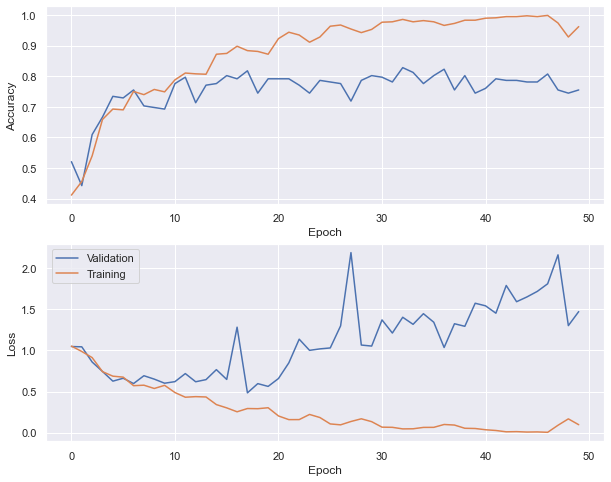

In [35]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist_inmetro.history['val_accuracy'],label='Validation')
axs[0].plot(hist_inmetro.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist_inmetro.history['val_loss'],label='Validation')
axs[1].plot(hist_inmetro.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();

## Test prediction

In [36]:
paths = ['Dados/desm1/',
             'Dados/desm2/',
             'Dados/desm3/']
length = 16000

def predict(model,experiments):
#     tp = [0,0,0]
#     fn = [0,0,0]
    acc = [0.,0.,0.]
    
    for class_desm in range(3):
        list_selected = paths[class_desm]
        for i in range(experiments):
            arq = np.random.choice(os.listdir(list_selected),1)[0]
            with open(list_selected+arq,'r') as f:
                read = f.readlines()
                x = np.array(read[2:]).astype(float)
                x = resize(x,length)
                x = x.reshape((1,input_shape[0],input_shape[1]))
                pred_desm = model.predict_classes(x)
    #             if class_desm == pred_desm:
    #                 tp[class_desm] += 1
    #             if class_desm != pred_desm:
    #                 fn[class_desm] += 1
                if class_desm == pred_desm:
                    acc[class_desm] += 1.
                
    acc = [x/float(experiments) for x in acc]
    return acc
    
predict(model_inmetro,100)

[0.98, 0.81, 0.86]

# Spectograms

## Zero-padding

In [3]:
def zero_pad(arr):
    arr = arr[:]
    _arr = arr.reshape((arr.shape[0],arr.shape[1],arr.shape[2],1))
    zer = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2],2))
    _arr = np.append(_arr,zer,axis=3)
    return _arr

## Extract 

In [444]:
def extract():
    paths = ['Espectogramas/desm1/',
         'Espectogramas/desm2/',
         'Espectogramas/desm3/']
    dados = []
    classes = []
    rows_correct,cols_correct = None,None
    for path in paths:
        list_arqs = os.listdir(path)
        for arq in list_arqs:
            with open(path+arq,'r') as f:
                read = f.read().split()
                rows,cols = np.array(read[:2]).astype(float).astype(int)
                x = np.array(read[2:]).astype(float).reshape((rows,cols))
                if (rows_correct,cols_correct) == (None,None):
                    rows_correct,cols_correct = rows,cols
                if (rows,cols) == (rows_correct,cols_correct):
                    dados.append(x)
                    classe = np.zeros(3)
                    classe[paths.index(path)] = 1.
                    classes.append(classe)
                
    dados = np.array(dados)
    classes = np.array(classes)
    dados = zero_pad(dados)
    dados,classes = shuffle(dados,classes,random_state=42)
    
    print(dados.shape)
    print(classes.shape)
    return dados, classes

dados,classes = extract()

(1166, 2, 307, 3)
(1166, 3)


## Remove bias

In [445]:
classes_count = count_classes(classes)
dados,classes = balance_data(dados,classes,classes_count,True);

(951, 2, 307, 3)
(951, 3)


# Train, test split

In [446]:
test_size = 0.4
X_train,X_test,y_train,y_test = train_test_split(dados,classes,test_size = test_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(570, 2, 307, 3)
(570, 3)
(381, 2, 307, 3)
(381, 3)


## Data Augmentation

In [448]:
batch_size = 16
val_size = 0.1
train_path = 'Espectogramas/'

aug = ImageDataGenerator(rescale=1./255.,
                         horizontal_flip=True,
                         vertical_flip=False,
                         brightness_range=(0.5,1.5),
                         validation_split=val_size)

train_generator = aug.flow(X_train,
                           y_train,
                           batch_size=batch_size,
                           subset = 'training')
                          

val_generator = aug.flow(X_train,
                         y_train,
                         batch_size=batch_size,
                         subset='validation')

test_generator = aug.flow(X_test,
                          y_test,
                          batch_size=batch_size)

## Train model

In [451]:
num_classes = classes.shape[1]
num_epochs = 150
input_shape = dados.shape[1:]

model = Sequential()
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile model
opt = SGD(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit_generator(train_generator, 
                              validation_data=val_generator, 
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(val_generator),
                              epochs=num_epochs, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 4 steps
Epoch 1/150
33/33 [==============================] - 1s 16ms/step - loss: 1.0909 - accuracy: 0.3762 - val_loss: 1.0970 - val_accuracy: 0.3860
Epoch 2/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1072 - accuracy: 0.3177 - val_loss: 1.1008 - val_accuracy: 0.3158
Epoch 3/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1164 - accuracy: 0.3099 - val_loss: 1.1015 - val_accuracy: 0.2982
Epoch 4/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1039 - accuracy: 0.3723 - val_loss: 1.0996 - val_accuracy: 0.2807
Epoch 5/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1056 - accuracy: 0.3216 - val_loss: 1.1009 - val_accuracy: 0.3860
Epoch 6/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1064 - accuracy: 0.3665 - val_loss: 1.0981 - val_accuracy: 0.3158
Epoch 7/150
33/33 [==============================] - 0s 5ms/st

33/33 [==============================] - 0s 5ms/step - loss: 1.1039 - accuracy: 0.3197 - val_loss: 1.0886 - val_accuracy: 0.4211
Epoch 58/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0944 - accuracy: 0.3665 - val_loss: 1.0908 - val_accuracy: 0.3684
Epoch 59/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0887 - accuracy: 0.3509 - val_loss: 1.0904 - val_accuracy: 0.3509
Epoch 60/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0943 - accuracy: 0.3567 - val_loss: 1.1085 - val_accuracy: 0.3684
Epoch 61/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1086 - accuracy: 0.3080 - val_loss: 1.0939 - val_accuracy: 0.3333
Epoch 62/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1051 - accuracy: 0.3548 - val_loss: 1.0921 - val_accuracy: 0.3860
Epoch 63/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1046 - accuracy: 0.3431 - val_loss: 1.0924 - val_accuracy: 0.3684
Epoch 64/150
33/33 

Epoch 115/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1042 - accuracy: 0.3294 - val_loss: 1.1018 - val_accuracy: 0.3509
Epoch 116/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0972 - accuracy: 0.3587 - val_loss: 1.0999 - val_accuracy: 0.3509
Epoch 117/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1082 - accuracy: 0.2924 - val_loss: 1.0903 - val_accuracy: 0.4035
Epoch 118/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0957 - accuracy: 0.3821 - val_loss: 1.0900 - val_accuracy: 0.3158
Epoch 119/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0981 - accuracy: 0.3197 - val_loss: 1.0864 - val_accuracy: 0.3509
Epoch 120/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1020 - accuracy: 0.3392 - val_loss: 1.1011 - val_accuracy: 0.2807
Epoch 121/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1063 - accuracy: 0.3392 - val_loss: 1.0958 - val_accuracy: 0.3509

## Evaluate model

In [452]:
#  evaluating model
_, acc = model.evaluate_generator(test_generator, 
                                  verbose=0)
print('Accuracy: %.3f' % (acc * 100.0))

model.save('Model_accuracy - %.3f' % (acc * 100.0) + '.h5')

  ...
    to  
  ['...']
Accuracy: 34.121


## Plot history

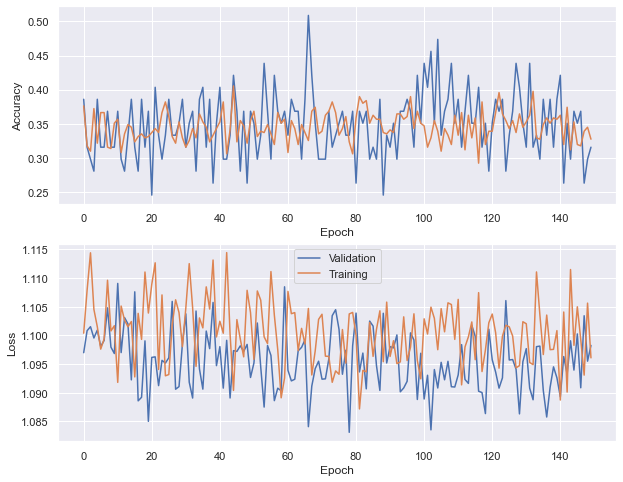

In [453]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist.history['val_accuracy'],label='Validation')
axs[0].plot(hist.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist.history['val_loss'],label='Validation')
axs[1].plot(hist.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();

## Test

In [362]:
def predict(model,class_desm):
    class_desm -= 1
    if class_desm < 0 or class_desm > 2:
        return "Erro"
    list_selected = paths[class_desm]
    arq = np.random.choice(os.listdir(list_selected),1)[0]
    print(list_selected+arq)
    with open(list_selected+arq,'r') as f:
        read = f.read().split()
        rows,cols = np.array(read[:2]).astype(float).astype(int)
        x = np.array(read[2:]).astype(float).reshape((1,rows,cols))
        x = zero_pad(x)
        print(x)
        pred = model.predict_classes(x)
        print(f"Classe Real: {class_desm+1}. Classe estimada: {pred+1}.")
        
predict(model,1)

Espectogramas/desm1/amostra_osso3_p4_5MHz_07Out2016_Rep01_Medicao1.txt
[[[[7.90980217e-19 0.00000000e+00 0.00000000e+00]
   [3.20417081e-18 0.00000000e+00 0.00000000e+00]
   [1.55615303e-17 0.00000000e+00 0.00000000e+00]
   ...
   [5.15902589e-19 0.00000000e+00 0.00000000e+00]
   [3.75057090e-20 0.00000000e+00 0.00000000e+00]
   [8.11168789e-19 0.00000000e+00 0.00000000e+00]]

  [[2.76371619e-17 0.00000000e+00 0.00000000e+00]
   [2.81629253e-16 0.00000000e+00 0.00000000e+00]
   [6.88866384e-16 0.00000000e+00 0.00000000e+00]
   ...
   [8.39085962e-18 0.00000000e+00 0.00000000e+00]
   [1.28133781e-17 0.00000000e+00 0.00000000e+00]
   [2.46717247e-17 0.00000000e+00 0.00000000e+00]]

  [[2.57537269e-17 0.00000000e+00 0.00000000e+00]
   [5.17740269e-17 0.00000000e+00 0.00000000e+00]
   [1.83843191e-16 0.00000000e+00 0.00000000e+00]
   ...
   [5.96471617e-17 0.00000000e+00 0.00000000e+00]
   [9.27855301e-18 0.00000000e+00 0.00000000e+00]
   [1.21972439e-17 0.00000000e+00 0.00000000e+00]]

  

# B-Mode

In [30]:
def extract_bmode():
    paths = ["B-mode/desm1/",
             "B-mode/desm2/",
             "B-mode/desm3/"]
    
    dados = []
    classes = []
    for path in paths:
        list_arqs = os.listdir(path)
        for arq in list_arqs:
            imgdata = cv.imread(path+arq,cv.IMREAD_GRAYSCALE)
            imgdata = cv.resize(imgdata, (108, 72),0,0)
            imgdata = imgdata[:,imgdata.shape[1]//2:]
#             imgdata = imgdata.reshape((imgdata.shape[0],imgdata.shape[1]))
            dados.append(imgdata)
            classe = np.zeros(3)
            classe[paths.index(path)] = 1.
            classes.append(classe)
                
    dados = np.array(dados)
    classes = np.array(classes)
    dados,classes = shuffle(dados,classes,random_state=42)
    print(dados.shape)
    print(classes.shape)
    return dados, classes

dados_bmode,classes_bmode = extract_bmode()

(1196, 72, 54)
(1196, 3)


## Remove bias

In [31]:
def count_classes(classes):
    classes_count = [0,0,0]

    for i in range(len(classes)):
        classes_count[np.where(classes[i]==1.)[0][0]] += 1

    return classes_count

classes_bmode_count = count_classes(classes_bmode)

def balance_data(dados,classes,classes_count,verbose=False):
    _dados = []
    _classes = []
    min_size = min(classes_count)
    classes_current = [0,0,0]
    for dado,classe in list(zip(dados,classes)):
        classe_int = np.where(classe==1.)[0][0]
        if classes_current[classe_int] < min_size:
            _dados.append(dado)
            _classes.append(classe)
            classes_current[classe_int] += 1
            
    _dados = np.array(_dados)
    _classes = np.array(_classes) 
    
    if verbose:
        print(_dados.shape)
        print(_classes.shape)
    
        
    return _dados,_classes

dados_bmode,classes_bmode = balance_data(dados_bmode,classes_bmode,classes_bmode_count,True)

(957, 72, 54)
(957, 3)


# Train, test split

In [32]:
test_size = 0.3
X_train,X_test,y_train,y_test = train_test_split(dados_bmode,classes_bmode,test_size = test_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(669, 72, 54)
(669, 3)
(288, 72, 54)
(288, 3)


## Data Augmentation

In [36]:
batch_size = 16
val_split = 0.3
image_size = (36,54)

train_path = 'B-mode/'

aug = ImageDataGenerator(rescale=1./255.,
                        horizontal_flip=True,
                        vertical_flip=False,
                        brightness_range=(0.5,1.5),
                        rotation_range=10,
                        validation_split=val_split)

train_generator = aug.flow_from_directory(train_path,
                                          color_mode = 'rgb',
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          subset='training')

val_generator = aug.flow_from_directory(train_path,
                                        color_mode = 'rgb',
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        subset='validation')



Found 839 images belonging to 3 classes.
Found 357 images belonging to 3 classes.


## Model with generator

In [15]:
num_classes = 3 
num_epochs = 10
input_shape = train_generator.next()[0].shape[1:]

model_bmode_gen = Sequential()
model_bmode_gen.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = input_shape, kernel_initializer = 'he_normal'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(MaxPooling2D((2, 2)))
model_bmode_gen.add(Dropout(0.25))

model_bmode_gen.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(MaxPooling2D((2, 2)))
model_bmode_gen.add(Dropout(0.25))

model_bmode_gen.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(MaxPooling2D((2, 2)))
model_bmode_gen.add(Dropout(0.25))

model_bmode_gen.add(Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(MaxPooling2D((2, 2)))
model_bmode_gen.add(Dropout(0.25))

model_bmode_gen.add(Flatten())
model_bmode_gen.add(Dense(256, activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(Dropout(0.5))
model_bmode_gen.add(Dense(128, activation = 'relu'))
model_bmode_gen.add(BatchNormalization())
model_bmode_gen.add(Dropout(0.5))
model_bmode_gen.add(Dense(num_classes, activation = 'softmax'))

# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
opt = SGD(lr=0.0001)
callback = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

model_bmode_gen.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

hist_bmode_generator = model_bmode_gen.fit_generator(train_generator, 
                                          steps_per_epoch=len(train_generator),
                                          validation_data=val_generator, 
                                          validation_steps=len(val_generator), 
                                          epochs=num_epochs,
                                          callbacks = callback,
                                          verbose=1)

(36, 54, 1)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 23 steps
Epoch 1/10
53/53 [==============================] - 5s 90ms/step - loss: 2.0595 - accuracy: 0.3385 - val_loss: 1.1089 - val_accuracy: 0.3557
Epoch 2/10
53/53 [==============================] - 4s 72ms/step - loss: 1.9870 - accuracy: 0.3385 - val_loss: 1.1656 - val_accuracy: 0.3697
Epoch 3/10
53/53 [==============================] - 4s 70ms/step - loss: 1.9407 - accuracy: 0.3361 - val_loss: 1.2003 - val_accuracy: 0.3838
Epoch 4/10
52/53 [============================>.] - ETA: 0s - loss: 2.1036 - accuracy: 0.3366 ETA: 0s - loss: 2.0958 - accuracy: 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
53/53 [==============================] - 4s 69ms/step - loss: 2.0992 - accuracy: 0.3361 - val_loss: 1.2415 - val_accuracy: 0.4006
Epoch 5/10
53/53 [==============================] - 4s 67ms/step - loss: 2.0075 - accuracy: 0.3421 - val_loss: 1.2724 - val_accuracy:

## Plot history

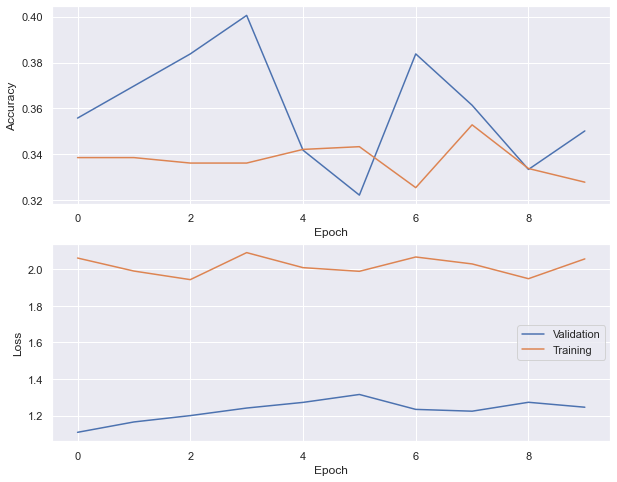

In [16]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist_bmode_generator.history['val_accuracy'],label='Validation')
axs[0].plot(hist_bmode_generator.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist_bmode_generator.history['val_loss'],label='Validation')
axs[1].plot(hist_bmode_generator.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();

### Model with cropped images

In [23]:
num_classes = 3 
num_epochs = 20
activation = 'relu'
input_shape = X_train.shape[1:]

model_bmode_crop = Sequential()

model_bmode_crop.add(Conv1D(filters=64, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model_bmode_gen.add(BatchNormalization())
model_bmode_crop.add(MaxPooling1D(pool_size=2))

model_bmode_crop.add(Conv1D(filters=128, kernel_size=5, input_shape=input_shape, activation=activation))
model_bmode_gen.add(BatchNormalization())
model_bmode_crop.add(MaxPooling1D(pool_size=2))

model_bmode_crop.add(Conv1D(filters=256, kernel_size=5, input_shape=input_shape, activation=activation))
model_bmode_gen.add(BatchNormalization())
model_bmode_crop.add(MaxPooling1D(pool_size=2))

model_bmode_crop.add(Conv1D(filters=128, kernel_size=5, input_shape=input_shape, activation=activation))
model_bmode_gen.add(BatchNormalization())
model_bmode_crop.add(MaxPooling1D(pool_size=2))

activation_dense = 'relu'

model_bmode_crop.add(Flatten())
model_bmode_crop.add(Dense(256, activation=activation_dense)) 
model_bmode_crop.add(Dropout(0.1))
model_bmode_crop.add(Dense(512, activation=activation_dense)) 
model_bmode_crop.add(Dropout(0.1))
model_bmode_crop.add(Dense(1024, activation=activation_dense))
model_bmode_crop.add(Dropout(0.1))
model_bmode_crop.add(Dense(3, activation='softmax'))

model_bmode_crop.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

hist_bmode_crop = model_bmode_crop.fit(X_train, 
                                     y_train, 
                                     batch_size=32, 
                                     epochs=num_epochs, 
                                     shuffle='True', 
                                     validation_data=(X_test, y_test))


Train on 837 samples, validate on 359 samples
Epoch 1/20
837/837 [==============================] - 1s 2ms/sample - loss: 3.5784 - accuracy: 0.3250 - val_loss: 1.0927 - val_accuracy: 0.3844
Epoch 2/20
837/837 [==============================] - 0s 249us/sample - loss: 1.1375 - accuracy: 0.3393 - val_loss: 1.0854 - val_accuracy: 0.4123
Epoch 3/20
837/837 [==============================] - 0s 244us/sample - loss: 1.1111 - accuracy: 0.3417 - val_loss: 1.0995 - val_accuracy: 0.3287
Epoch 4/20
837/837 [==============================] - 0s 254us/sample - loss: 1.0937 - accuracy: 0.3656 - val_loss: 1.0857 - val_accuracy: 0.3983
Epoch 5/20
837/837 [==============================] - 0s 233us/sample - loss: 1.1003 - accuracy: 0.3548 - val_loss: 1.0885 - val_accuracy: 0.3844
Epoch 6/20
837/837 [==============================] - 0s 237us/sample - loss: 1.0942 - accuracy: 0.3656 - val_loss: 1.0843 - val_accuracy: 0.3983
Epoch 7/20
837/837 [==============================] - 0s 238us/sample - loss: 1.

## Plot history

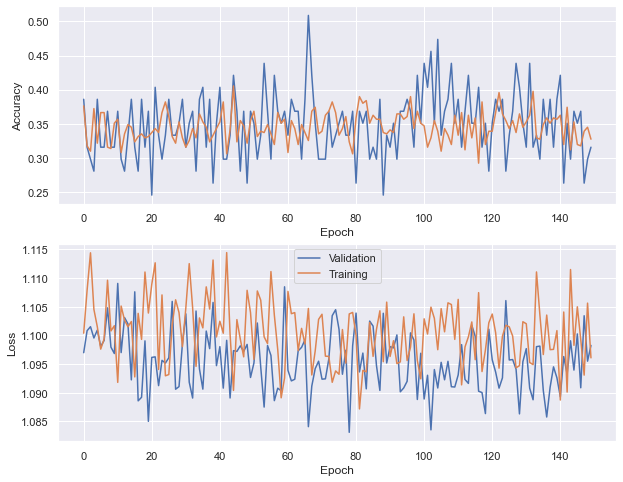

In [453]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist.history['val_accuracy'],label='Validation')
axs[0].plot(hist.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist.history['val_loss'],label='Validation')
axs[1].plot(hist.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();

### Transfer Learning

In [43]:
num_classes = 3 
num_epochs = 100
input_shape = train_generator.next()[0].shape[1:]

custom_input = Input(shape=input_shape)

base_model = ResNet101(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape,
                  classes=num_classes)

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = True
    
# add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation=activation_dense)(x)
x = Dropout(0.1)(x)
x = Dense(512, activation=activation_dense)(x) 
x = Dropout(0.1)(x)
x = Dense(1024, activation=activation_dense)(x) 
x = Dropout(0.1)(x)
output = Dense(num_classes,activation = 'softmax')(x)


# define new model
model_transf = Model(inputs=base_model.inputs, outputs=output)



# compile model
opt = SGD(lr=0.01)
model_transf.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

hist_transf = model_transf.fit_generator(train_generator, 
                                         steps_per_epoch=len(train_generator),
                                         validation_data=val_generator, 
                                         validation_steps=len(val_generator), 
                                         epochs=num_epochs, 
                                         verbose=1)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 53 steps, validate for 23 steps
Epoch 1/100
53/53 [==============================] - 18s 330ms/step - loss: 1.1795 - accuracy: 0.3790 - val_loss: 1.1476 - val_accuracy: 0.3838
Epoch 2/100
53/53 [==============================] - 9s 174ms/step - loss: 1.1327 - accuracy: 0.3754 - val_loss: 1.1132 - val_accuracy: 0.3838
Epoch 3/100
53/53 [==============================] - 9s 173ms/step - loss: 1.1272 - accuracy: 0.4005 - val_loss: 1.0948 - val_accuracy: 0.3585
Epoch 4/100
53/53 [==============================] - 9s 172ms/step - loss: 1.0923 - accuracy: 0.3981 - val_loss: 1.1090 - val_accuracy: 0.3501
Epoch 5/100
53/53 [==============================] - 9s 172ms/step - loss: 1.0942 - accuracy: 0.3909 - val_loss: 1.1088 - val_accuracy: 0.3725
Epoch 6/100
53/53 [==============================] - 9s 174ms/step - loss: 1.0703 - accuracy: 0.4279 - val_loss: 1.1854 - val_accuracy: 0.3557
Epoch 7/100
53/53 [==============================

## Plot history

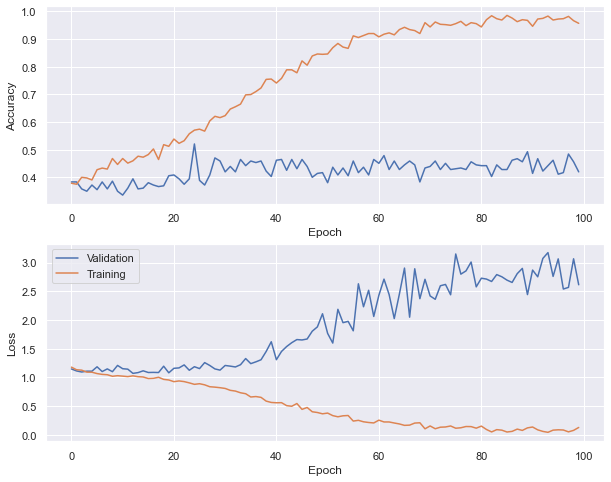

In [44]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist_transf.history['val_accuracy'],label='Validation')
axs[0].plot(hist_transf.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist_transf.history['val_loss'],label='Validation')
axs[1].plot(hist_transf.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();